# Convert Real-ESRGAN Model to ONNX and OpenVINO™ IR

This tutorial demonstrates step-by-step instructions on how to do inference on a PyTorch image restoration model, using OpenVINO Runtime.

First, the PyTorch model is exported in [ONNX](https://onnx.ai/) format and then converted to OpenVINO IR. Then the respective ONNX and OpenVINO IR models are loaded into OpenVINO Runtime to show model predictions.
In this tutorial we will use [Real-ESRGAN ](https://github.com/xinntao/Real-ESRGAN) pre-trained model. 

According to the paper, [Real-ESRGAN: Training Real-World Blind Super-Resolution with Pure Synthetic Data](https://arxiv.org/pdf/2107.10833.pdf), : Real-ESRGAN adopts the same generator network as that in ESRGAN. For the scale factor of ×2 and ×1, it first
employs a pixel-unshuffle operation to reduce spatial size and re-arrange information to the channel dimension:

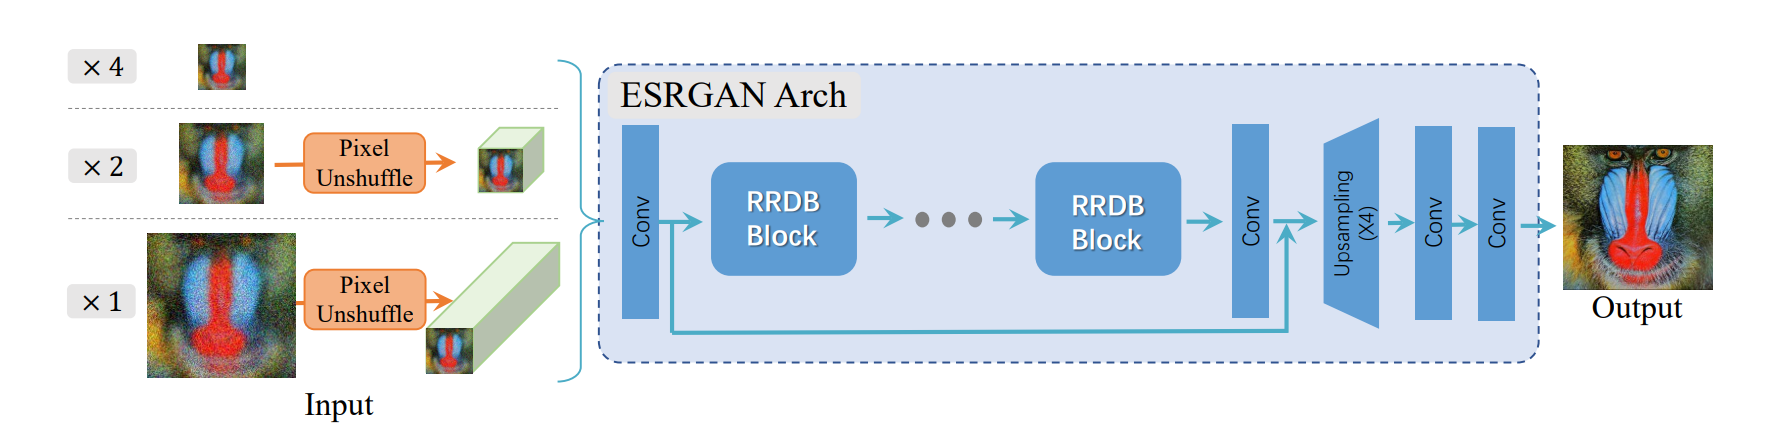

Similar to ESRGAN, the modle adopted DIV2K, Flickr2K and OutdoorSceneTraining datasets for training. The training HR patch size is set to 256. Models are trained with four NVIDIA V100 GPUs with a total batch size of 48. Adam optimizer employed.

## Preparation

### Imports

In [1]:
import sys
import time
import warnings
from pathlib import Path

import cv2
import numpy as np
import torch
from IPython.display import Markdown, display
from openvino.runtime import Core

import matplotlib.pyplot as plt
from matplotlib import image as mpimg

import torch.onnx
from basicsr.archs.rrdbnet_arch import RRDBNet

sys.path.append("../utils")
from notebook_utils import download_file, viz_result_image

### Settings

Set a name for the model, then define width and height of the image that will be used by the network during inference. According to the input transforms function, the model is pretrained on images with a height of 520 and width of 780.

In [2]:
DIRECTORY_NAME = "model"
BASE_MODEL_NAME = DIRECTORY_NAME + "/RealESRGAN_x4plus"
weights_path = Path(BASE_MODEL_NAME + ".pth")

# Paths where ONNX and OpenVINO IR models will be stored.
onnx_path = weights_path.with_suffix('.onnx')
if not onnx_path.parent.exists():
    onnx_path.parent.mkdir()
ir_path = onnx_path.with_suffix(".xml")

### Load Model

Generally, PyTorch models represent an instance of `torch.nn.Module` class, initialized by a state dictionary with model weights.
Typical steps for getting a pretrained model:
1. Download pytorch pretrained model weights .pt/.pth file
2. Create instance of model class, [RRDB architecture](https://github.com/XPixelGroup/BasicSR/blob/master/basicsr/archs/rrdbnet_arch.py)
3. Load checkpoint state dict, which contains pretrained model weights
4. Turn model to evaluation for switching some operations to inference mode
    

In [3]:
print("Downloading the RealESRGAN_x4plus model (if it has not been downloaded already)...") 

MODEL_LINK = "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth"
download_file(MODEL_LINK, filename=weights_path.name, directory=weights_path.parent)

# create model object
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
# read state dict, use map_location argument to avoid a situation where weights are saved in cuda (which may not be unavailable on the system)
state_dict = torch.load(weights_path, map_location='cpu')
# load state dict to model
model.load_state_dict(state_dict['params_ema'])
# switch model from training to inference mode
model.train(False)
model.cpu().eval()

print("Loaded PyTorch RealESRGAN_x4plus model")

model/RealESRGAN_x4plus.pth:   0%|          | 0.00/63.9M [00:00<?, ?B/s]

Loaded PyTorch RealESRGAN_x4plus model


## ONNX Model Conversion

### Convert PyTorch model to ONNX

OpenVINO supports PyTorch\* models that are exported in ONNX\* format. We will use the `torch.onnx.export` function to obtain the ONNX model, you can learn more about this feature in the [PyTorch documentation](https://pytorch.org/docs/stable/onnx.html), We need to provide a model object, example input for model tracing and path where the model will be saved. When providing example input, it is not necessary to use real data, dummy input data with specified shape is sufficient. Optionally, we can provide a target onnx opset for conversion and/or other parameters specified in documentation (e.g. input and output names or dynamic shapes).

Sometimes a warning will be shown, but in most cases it's harmless, so let's just filter it out. When the conversion is successful, the last line of the output will read: `ONNX model exported to model/RealESRGAN_x4plus.onnx.` 

In [4]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    if not onnx_path.exists():
        dummy_input = torch.rand(1, 3, 64, 64)
        input_names=['data']
        output_names=['output']
        dynamic_axes= {'data':{2:'width', 3:'height'}, 'output':{2:'width', 3:'height'}}

        torch.onnx.export(
            model,
            dummy_input,
            onnx_path,
            input_names=input_names, 
            output_names=output_names, 
            dynamic_axes=dynamic_axes,
        )
        print(f"ONNX model exported to {onnx_path}.")
    else:
        print(f"ONNX model {onnx_path} already exists.")

ONNX model exported to model/RealESRGAN_x4plus.onnx.


### Convert ONNX Model to OpenVINO IR Format

Use Model Optimizer to convert the ONNX model to OpenVINO IR with `FP16` precision. The models are saved inside the current directory. For more information about Model Optimizer, see the [Model Optimizer Developer Guide](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html).

Executing this command may take a while. There may be some errors or warnings in the output. When Model Optimization is successful, the last lines of the output will include: `[ SUCCESS ] Generated IR version 11 model.`

In [5]:
# Construct the command for Model Optimizer.
mo_command = f"""mo
                 --input_model "{onnx_path}"
                 --compress_to_fp16
                 --output_dir "{ir_path.parent}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert the ONNX model to OpenVINO:")
display(Markdown(f"`{mo_command}`"))

Model Optimizer command to convert the ONNX model to OpenVINO:


`mo --input_model "model/RealESRGAN_x4plus.onnx" --compress_to_fp16 --output_dir "model"`

In [6]:
if not ir_path.exists():
    print("Exporting ONNX model to IR... This may take a few minutes.")
    mo_result = %sx $mo_command
    print("\n".join(mo_result))
else:
    print(f"IR model {ir_path} already exists.")

Exporting ONNX model to IR... This may take a few minutes.
[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /home/adham/Intel Contrb/openvino_notebooks/notebooks/274-Real-ESRGAN-image-restoration/model/RealESRGAN_x4plus.xml
[ SUCCESS ] BIN file: /home/adham/Intel Contrb/openvino_notebooks/notebooks/274-Real-ESRGAN-image-restoration/model/RealESRGAN_x4plus.bin


## Show Results

Confirm that the results look as expected by comparing model results on the ONNX, OpenVINO IR and PyTorch models.

### Load and Preprocess an Input Image

Images need to be normalized before propagating through the network.

loaded input image.
Output shape: torch.Size([1, 3, 256, 256])
<class 'torch.Tensor'>


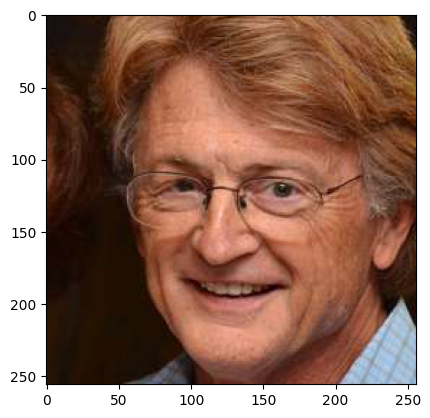

In [7]:
#Original low dimenional unenhanced image 

orig_img = mpimg.imread("../data/image/lr_face.png")
plt.imshow(orig_img)

img = cv2.imread('../data/image/lr_face.png', cv2.IMREAD_COLOR).astype(np.float32) / 255.

img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]],
                                        (2, 0, 1))).float()
img = img.unsqueeze(0).to('cpu')

print("loaded input image.")
print("Output shape:", img.shape)
print(type(img))

## PyTorch Original Model

Do inference on the PyTorch model and then we will verify that the output alligns with output on the ONNX/OpenVINO IR models.

In [8]:
num_images = 1

model.cpu().eval()
model = model.to('cpu')


# Pytorch model inference and preformance evaluation
with torch.no_grad():
    start = time.perf_counter()
    for _ in range(num_images):
        result_torch = model(img)
        end = time.perf_counter()
        time_torch = end - start
print(
    f"PyTorch model on CPU: {time_torch/num_images:.3f} seconds per image, "
    f"FPS: {num_images/time_torch:.2f}"   
)

PyTorch model on CPU: 17.025 seconds per image, FPS: 0.06


In [9]:
# 4X Scaled and enhanced image 

print("Output shape:", result_torch.shape)

Output shape: torch.Size([1, 3, 1024, 1024])


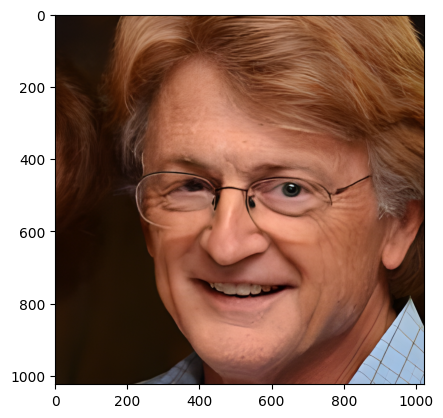

In [10]:
# save imageresult_torch
result_torch = result_torch.data.squeeze().float().cpu().clamp_(0, 1).numpy()
result_torch = np.transpose(result_torch[[2, 1, 0], :, :], (1, 2, 0))
result_torch = (result_torch * 255.0).round().astype(np.uint8)
cv2.imwrite('output/result_torch.png', result_torch)

# Visualize result output
res_img = mpimg.imread("output/result_torch.png")
plt.imshow(res_img)

### Load the OpenVINO IR Network and Run Inference on the ONNX model

OpenVINO Runtime can load ONNX models directly. First, load the ONNX model, do inference and show the results. Then, load the model that was converted to OpenVINO Intermediate Representation (OpenVINO IR) with Model Optimizer and do inference on that model, and show the results.

#### 1. ONNX Model in OpenVINO Runtime

In [11]:
# Load the network to OpenVINO Runtime.
ie = Core()
model_onnx = ie.read_model(model=onnx_path)
compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

output_layer_onnx = compiled_model_onnx.output(0)

# Run inference and test ONNX model performance on the input image.
start = time.perf_counter()
for _ in range(num_images):
    res_onnx = compiled_model_onnx([img])[output_layer_onnx]
end = time.perf_counter()
time_onnx = end - start
print(
    f"ONNX model in OpenVINO Runtime/CPU: {time_onnx/num_images:.3f} "
    f"seconds per image, FPS: {num_images/time_onnx:.2f}"
)

ONNX model in OpenVINO Runtime/CPU: 11.629 seconds per image, FPS: 0.09


In [12]:
# Same result with original pytorch Model

print("Output shape:", res_onnx.shape)
print(type(res_onnx))

Output shape: (1, 3, 1024, 1024)
<class 'numpy.ndarray'>


#### 2. OpenVINO IR Model in OpenVINO Runtime

In [13]:
# Load the network in OpenVINO Runtime.
ie = Core()
model_ir = ie.read_model(model=ir_path)
compiled_model_ir = ie.compile_model(model=model_ir, device_name="CPU")

# Get input and output layers.
output_layer_ir = compiled_model_ir.output(0)

# Run inference and test IR model performance on the input image.
start = time.perf_counter()
for _ in range(num_images):
    res_ir = compiled_model_ir([img])[output_layer_ir]
end = time.perf_counter()
time_ir = end - start
print(
    f"OpenVINO IR model in OpenVINO Runtime/CPU: {time_ir/num_images:.3f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}"
)

OpenVINO IR model in OpenVINO Runtime/CPU: 10.523 seconds per image, FPS: 0.10


In [14]:
# Same result with the previous ONNX and pytorch models.

print("Output shape:", res_ir.shape)

Output shape: (1, 3, 1024, 1024)


**Show Device Information**

In [15]:
devices = ie.available_devices
for device in devices:
    device_name = ie.get_property(device, "FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

CPU: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz


## References

* [Torchvision](https://pytorch.org/vision/stable/index.html)
* [Pytorch ONNX Documentation](https://pytorch.org/docs/stable/onnx.html)
* [PIP install openvino-dev](https://pypi.org/project/openvino-dev/)
* [OpenVINO ONNX support](https://docs.openvino.ai/2021.4/openvino_docs_IE_DG_ONNX_Support.html)
* [Model Optimizer Documentation](https://docs.openvino.ai/latest/openvino_docs_MO_DG_prepare_model_convert_model_Converting_Model_General.html)
* [Model Optimizer Pytorch conversion guide](https://docs.openvino.ai/latest/openvino_docs_MO_DG_prepare_model_convert_model_Convert_Model_From_PyTorch.html)
